# The "Hazardous Delivery" DPO Project Guide

**Project Goal**: Train an agent to navigate a grid, avoid "Lava" (instant death), and prefer "Safe Paths" over "Risky Short Paths" using only human gameplay data (DPO), not mathematical reward shaping.

# Step 1: Setup & Library Installation

In [1]:
# Install gymnasium and strictly pin numpy to avoid version 2.0 conflicts
!pip install gymnasium matplotlib ipywidgets torch

# Step 2: The Custom Environment

This is your custom game logic. It simulates a grid where:

- S: Start (Top Left)

- G: Goal (Bottom Right)

- L: Lava (Instant death)

- Safe Path: Longer but safe.

- Risky Path: Short but next to lava.

In [7]:
# --- CELL 2: UPDATED ENVIRONMENT ---
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

class HazardGridEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.size = 5
        # Actions: 0=Up, 1=Down, 2=Left, 3=Right
        self.action_space = spaces.Discrete(4)

        # Observation: Agent (x,y) coordinates
        # We explicitly set dtype to int32 to match Numpy 2.0 requirements
        self.observation_space = spaces.Box(
            low=0,
            high=self.size-1,
            shape=(2,),
            dtype=np.int32
        )

        self.grid_layout = np.zeros((self.size, self.size), dtype=np.int32)
        # Lava blocks
        self.grid_layout[1, 1:3] = 1
        self.grid_layout[2, 2] = 1

        self.agent_pos = np.array([0, 0], dtype=np.int32)
        self.goal_pos = np.array([4, 4], dtype=np.int32)
        self.max_steps = 20
        self.current_step = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.agent_pos = np.array([0, 0], dtype=np.int32)
        self.current_step = 0
        # STRICT CASTING to int32 to fix warnings
        return self.agent_pos.astype(np.int32), {}

    def step(self, action):
        self.current_step += 1

        direction = {0: [-1, 0], 1: [1, 0], 2: [0, -1], 3: [0, 1]}
        move = np.array(direction.get(int(action), [0, 0]), dtype=np.int32)

        new_pos = self.agent_pos + move
        new_pos = np.clip(new_pos, 0, self.size-1)

        # Check for Lava
        if self.grid_layout[new_pos[0], new_pos[1]] == 1:
            reward = -10
            terminated = True
            truncated = False
            # STRICT CASTING
            return new_pos.astype(np.int32), reward, terminated, truncated, {"outcome": "died"}

        self.agent_pos = new_pos

        # Check Goal
        if np.array_equal(self.agent_pos, self.goal_pos):
            reward = 10
            terminated = True
            truncated = False
            # STRICT CASTING
            return self.agent_pos.astype(np.int32), reward, terminated, truncated, {"outcome": "won"}

        truncated = self.current_step >= self.max_steps
        terminated = False

        # STRICT CASTING
        return self.agent_pos.astype(np.int32), -0.1, terminated, truncated, {}

    def render(self):
        grid = [['.' for _ in range(self.size)] for _ in range(self.size)]
        for r in range(self.size):
            for c in range(self.size):
                if self.grid_layout[r, c] == 1:
                    grid[r][c] = 'X'
        grid[0][0] = 'S'
        grid[4][4] = 'G'
        curr_r, curr_c = self.agent_pos
        grid[curr_r][curr_c] = 'A'

        print("-" * 10)
        for row in grid:
            print(" ".join(row))
        print("-" * 10)

# Re-register to apply changes
try:
    gym.envs.registration.register(
        id='HazardGrid-v0',
        entry_point=__name__ + ':HazardGridEnv',
        max_episode_steps=20,
    )
except:
    pass

/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:636: UserWarning: WARN: Overriding environment HazardGrid-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


# Step 3: Data Collection

Task: Play the game 5-10 times.

- Try to win by taking the LONG way around (Safe).

- Try to die explicitly by hitting Lava.

- We need both "winning" and "losing" data for DPO to work well.

In [8]:
# --- CELL 3: DATA COLLECTION ---
import ipywidgets as widgets
from IPython.display import display
import torch

# 1. INITIALIZE DATASET GLOBALLY
# This line prevents the NameError.
# If you restart the runtime, you MUST run this cell again.
dataset = []
current_episode_data = []

env = gym.make('HazardGrid-v0')
obs, _ = env.reset()

out = widgets.Output()
status_label = widgets.Label(value="Dataset Size: 0 samples")

def on_button_click(b):
    # We use 'global' to ensure we are writing to the main variable
    global obs, current_episode_data, dataset

    action_map = {'Up': 0, 'Down': 1, 'Left': 2, 'Right': 3}
    action = action_map[b.description]

    next_obs, reward, done, truncated, info = env.step(action)

    # Store step
    current_episode_data.append((obs, action))
    obs = next_obs

    with out:
        clear_output(wait=True)
        env.render()

        if done or truncated:
            outcome = info.get('outcome', 'timeout')
            print(f"Episode Finished! Outcome: {outcome}")

            # Label: 1 if Won, 0 if Died/Timeout
            label = 1 if outcome == 'won' else 0

            # Save to GLOBAL dataset
            for state, act in current_episode_data:
                dataset.append({'state': state, 'action': act, 'label': label})

            # Update the visual counter
            status_label.value = f"Dataset Size: {len(dataset)} samples"

            current_episode_data = [] # Clear temp buffer
            obs, _ = env.reset()
            env.render()

# Setup UI
btn_up = widgets.Button(description='Up')
btn_down = widgets.Button(description='Down')
btn_left = widgets.Button(description='Left')
btn_right = widgets.Button(description='Right')

btn_up.on_click(on_button_click)
btn_down.on_click(on_button_click)
btn_left.on_click(on_button_click)
btn_right.on_click(on_button_click)

print("INSTRUCTIONS: Play 5-10 times. Try to WIN some and DIE in some.")
print("Check the 'Dataset Size' counter below to ensure data is saving.")

display(widgets.VBox([
    status_label,
    btn_up,
    widgets.HBox([btn_left, btn_right]),
    btn_down
]), out)

with out:
    env.render()

INSTRUCTIONS: Play 5-10 times. Try to WIN some and DIE in some.
Check the 'Dataset Size' counter below to ensure data is saving.


Output()

# Step 4: The DPO Model : Feed Forward Neural Network

1- Policy Network: The one we train.
2- Reference Network: A frozen copy. DPO prevents the agent from straying too far from this baseline while maximizing the gap between "good" and "bad" actions.

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 1. Define the Neural Network
class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 4) # 4 Actions

    def forward(self, x):
        x = torch.FloatTensor(x).to(device)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

# 2. Initialize Models
policy_model = PolicyNet().to(device)
ref_model = PolicyNet().to(device)
ref_model.load_state_dict(policy_model.state_dict()) # Exact copy
ref_model.eval() # Freeze reference model

optimizer = optim.Adam(policy_model.parameters(), lr=0.01)

# 3. Prepare Data for DPO
# We need pairs: (State, Good_Action, Bad_Action)
# To simplify, we will filter our dataset into "Winning" steps and "Losing" steps
# and treat them as preferences.
winning_data = [d for d in dataset if d['label'] == 1]
losing_data = [d for d in dataset if d['label'] == 0]

print(f"Collected {len(winning_data)} winning steps and {len(losing_data)} losing steps.")

Training on: cuda
Collected 52 winning steps and 23 losing steps.


# Step 5: The DPO Training Loop

The code below implements the mathematical formula for Direct Preference Optimization, calculating the log-sigmoid of the difference between preferred and rejected policy ratios.

Training on: cuda
Training on 75 samples (52 Wins).
Starting Training...
Epoch 0: Loss 0.6411
Epoch 50: Loss 0.5536
Epoch 100: Loss 0.5577
Epoch 150: Loss 0.5480
Epoch 200: Loss 0.5189
Epoch 250: Loss 0.5187
Epoch 300: Loss 0.5122
Epoch 350: Loss 0.5165
Epoch 400: Loss 0.5172
Epoch 450: Loss 0.5137
Training Complete!


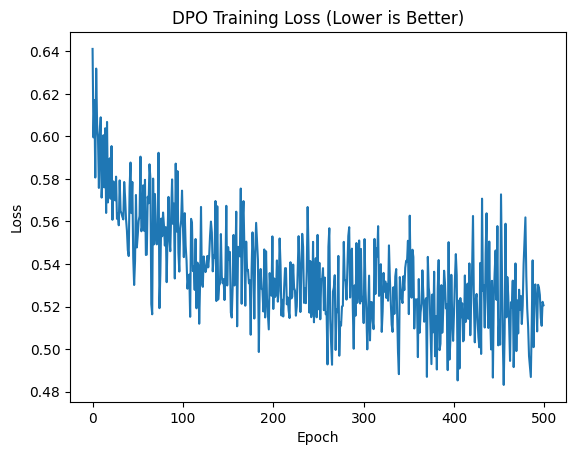

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# --- 1. SETUP MODEL ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        # Ensure input is float tensor on the correct device
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32).to(device)
        x = x.to(device) # Ensure device
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Initialize Models
policy_model = PolicyNet().to(device)
ref_model = PolicyNet().to(device)
ref_model.load_state_dict(policy_model.state_dict())
ref_model.eval()

optimizer = optim.Adam(policy_model.parameters(), lr=0.005)

# --- 2. PREPARE DATA ---
# We verify the dataset is not empty
if len(dataset) == 0:
    raise ValueError("DATASET IS EMPTY! Please go back to Step 3 and play the game.")

# Split into Winning (1) and Losing (0) for reporting, but we train on both
winning_len = len([d for d in dataset if d['label'] == 1])
print(f"Training on {len(dataset)} samples ({winning_len} Wins).")

# --- 3. DPO LOSS FUNCTION ---
def dpo_loss(policy_logits, ref_logits, actions, labels):
    # Get log probabilities
    policy_log_probs = F.log_softmax(policy_logits, dim=1)
    ref_log_probs = F.log_softmax(ref_logits, dim=1)

    # Gather specific log-probs for the actions taken
    policy_act_prob = policy_log_probs.gather(1, actions.unsqueeze(1))
    ref_act_prob = ref_log_probs.gather(1, actions.unsqueeze(1))

    # DPO Logic
    logits_diff = policy_act_prob - ref_act_prob

    # Convert labels to tensor safely
    # We use np.array first to prevent device errors
    target = torch.tensor(np.array(labels), dtype=torch.float32).to(device)
    target = target * 2 - 1 # Convert [0,1] -> [-1, 1]

    beta = 0.5
    loss = -torch.log(torch.sigmoid(beta * logits_diff.squeeze() * target)).mean()
    return loss

# --- 4. TRAINING LOOP ---
epochs = 500
batch_size = 32
loss_history = []

# Shuffle helper
full_data = dataset.copy()
import random

print("Starting Training...")
for epoch in range(epochs):
    random.shuffle(full_data)

    epoch_loss = 0
    count = 0

    for i in range(0, len(full_data), batch_size):
        batch = full_data[i:i+batch_size]
        if not batch: continue

        # --- THE FIX: USE NUMPY FIRST ---
        # This strips away any conflicting device info
        state_batch = np.array([b['state'] for b in batch])
        action_batch = np.array([b['action'] for b in batch])
        label_batch = [b['label'] for b in batch]

        # Now convert to Tensor
        states = torch.tensor(state_batch, dtype=torch.float32).to(device)
        actions = torch.tensor(action_batch, dtype=torch.long).to(device)

        optimizer.zero_grad()

        policy_logits = policy_model(states)
        with torch.no_grad():
            ref_logits = ref_model(states)

        loss = dpo_loss(policy_logits, ref_logits, actions, label_batch)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        count += 1

    if count > 0:
        loss_history.append(epoch_loss / count)

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss {epoch_loss/count:.4f}")

print("Training Complete!")
plt.plot(loss_history)
plt.title("DPO Training Loss (Lower is Better)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Step 6: Watch the Agent Play

- Now we let the AI play by itself using the trained policy.

In [15]:
# --- CELL 6: TEST AGENT ---
import time

env = gym.make('HazardGrid-v0')
obs, _ = env.reset()
done = False

print("--- AI AGENT PLAYING ---")
# Increase visualization size for Colab
env.render()

for _ in range(20): # Max 20 steps
    # Prepare input
    # We wrap in np.array and then torch to match training format
    obs_tensor = torch.tensor(np.array([obs]), dtype=torch.float32).to(device)

    with torch.no_grad():
        logits = policy_model(obs_tensor)
        action = torch.argmax(logits).item() # Pick best action

    obs, reward, done, truncated, info = env.step(action)

    print(f"Agent moved: {['Up','Down','Left','Right'][action]}")
    env.render()

    if done:
        print(f"GAME OVER: {info.get('outcome')}")
        break
    time.sleep(0.5)

--- AI AGENT PLAYING ---
----------
A . . . .
. X X . .
. . X . .
. . . . .
. . . . G
----------
Agent moved: Right
----------
S A . . .
. X X . .
. . X . .
. . . . .
. . . . G
----------
Agent moved: Right
----------
S . A . .
. X X . .
. . X . .
. . . . .
. . . . G
----------
Agent moved: Right
----------
S . . A .
. X X . .
. . X . .
. . . . .
. . . . G
----------
Agent moved: Down
----------
S . . . .
. X X A .
. . X . .
. . . . .
. . . . G
----------
Agent moved: Down
----------
S . . . .
. X X . .
. . X A .
. . . . .
. . . . G
----------
Agent moved: Down
----------
S . . . .
. X X . .
. . X . .
. . . A .
. . . . G
----------
Agent moved: Down
----------
S . . . .
. X X . .
. . X . .
. . . . .
. . . A G
----------
Agent moved: Right
----------
S . . . .
. X X . .
. . X . .
. . . . .
. . . . A
----------
GAME OVER: won
